---
jupyter: python3
execute:
  cache: true
---

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import re
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, classification_report
from joblib import Parallel, delayed

In [ ]:
DATA_PATH = "../../data/"
MVG_FILE = "subway_only_dedup.parquet"
EVENTS_FILE = "events.csv"
HOLIDAYS_FILE = "public_holiday.csv"
ALLIANZ_FILE = "allianz_arena_events.csv"
WEATHER_FILE = "weather_2024-2025.csv"

In [ ]:
def load_data(path, mvg_file, events_file, holidays_file, allianz_file, weather_file):
    mvg_data = pd.read_parquet(path + mvg_file)
    events_df = pd.read_csv(path + events_file, parse_dates=['start_date', 'end_date'])
    public_holiday_df = pd.read_csv(path + holidays_file, parse_dates=['date'])
    allianz_arena_df = pd.read_csv(path + allianz_file, parse_dates=['date'])
    weather_df = pd.read_csv(path + weather_file, parse_dates=['date'])
    return mvg_data, events_df, public_holiday_df, allianz_arena_df, weather_df

mvg_data_orig, events_df, public_holiday_df, allianz_arena_df, weather_df = load_data(
    DATA_PATH, MVG_FILE, EVENTS_FILE, HOLIDAYS_FILE, ALLIANZ_FILE, WEATHER_FILE
)

In [ ]:
mvg_data = mvg_data_orig

mvg_data = mvg_data.drop(columns=['transportType', 'realtimeDepartureTime', 'timestamp'])
mvg_data = mvg_data[mvg_data.realtime]
mvg_data['onTime'] = mvg_data['delayInMinutes'] == 0

mvg_datetime = pd.to_datetime(mvg_data['plannedDepartureTime']).dt
mvg_data['plannedDepartureTime_dt'] = pd.to_datetime(mvg_data['plannedDepartureTime'])

#mvg_data['hourOfDay'] = mvg_datetime.hour

mvg_data['minuteOfDay'] = mvg_datetime.hour * 60 + mvg_datetime.minute
# encode minute of day as 23:00 and 00:00 are far apart but close in reality
mvg_data['minuteSin'] = np.sin(2 * np.pi * mvg_data['minuteOfDay'] / 1440)
mvg_data['minuteCos'] = np.cos(2 * np.pi * mvg_data['minuteOfDay'] / 1440)


mvg_data['dayOfWeek'] = mvg_datetime.day_of_week # Monday=0, Sunday=6
#mvg_data['dayOfYear'] = mvg_datetime.day_of_year

mvg_data['isRushHour'] = mvg_datetime.hour.between(7, 9) | mvg_datetime.hour.between(16, 18)
mvg_data['isWeekend'] = mvg_data['dayOfWeek'] >= 5 # Saturday=5, Sunday=6

# remove negative delay for bucketing
mvg_data = mvg_data[mvg_data['delayInMinutes'] >= 0]

# only use u6
mvg_data = mvg_data[mvg_data['label'] == 'U6']

# include events
mvg_data['isMajorEvent'] = False
for index, event in events_df.iterrows():
    event_mask = (
        (mvg_data['plannedDepartureTime_dt'].dt.date >= event['start_date'].date()) &
        (mvg_data['plannedDepartureTime_dt'].dt.date <= event['end_date'].date())
    )
    mvg_data.loc[event_mask, 'isMajorEvent'] = True
print("\nEvent day departures vs. normal day departures:")
print(mvg_data['isMajorEvent'].value_counts())


# set if public holiday is true
holiday_dates = set(public_holiday_df['date'].dt.date)
mvg_data['isHoliday'] = mvg_data['plannedDepartureTime_dt'].dt.date.isin(holiday_dates)
print("\nHoliday departures vs. normal day departures:")
print(mvg_data['isHoliday'].value_counts())

# include allianz arena events
allianz_arena_dates = set(allianz_arena_df['date'].dt.date)
mvg_data['isAllianzArenaEvent'] = mvg_data['plannedDepartureTime_dt'].dt.date.isin(allianz_arena_dates)
print("\nAllianz Arena Event departures vs. normal day departures:")
print(mvg_data['isAllianzArenaEvent'].value_counts())

#include weather
weather_df['date'] = pd.to_datetime(weather_df['date'], format='%d.%m.%Y')
mvg_data = pd.merge(
    mvg_data,
    weather_df,
    how='left',
    left_on=mvg_data['plannedDepartureTime_dt'].dt.date,
    right_on=weather_df['date'].dt.date
)
mvg_data = mvg_data.drop(columns=['key_0', 'date'])
nan_weather_rows = mvg_data['tempAvg'].isnull().sum()
if nan_weather_rows > 0:
    print(f"Warning: {nan_weather_rows} rows did not have matching weather data and contain NaNs.")


#bins = [float('-inf'), 2, np.inf]
#labels = ['On Time', 'Delayed']
#mvg_data['delayCategory'] = pd.cut(mvg_data['delayInMinutes'], bins=bins, labels=labels)

print("New binary class distribution:\n", mvg_data['onTime'].value_counts())


Event day departures vs. normal day departures:
isMajorEvent
False    3204709
True      249221
Name: count, dtype: int64

Holiday departures vs. normal day departures:
isHoliday
False    3386613
True       67317
Name: count, dtype: int64

Allianz Arena Event departures vs. normal day departures:
isAllianzArenaEvent
False    3153279
True      300651
Name: count, dtype: int64
New binary class distribution:
 onTime
True     3239816
False     214114
Name: count, dtype: int64


In [ ]:
mvg_data.sample(5)

,station,plannedDepartureTime,realtime,delayInMinutes,label,destination,onTime,plannedDepartureTime_dt,minuteOfDay,minuteSin,...,isMajorEvent,isHoliday,isAllianzArenaEvent,tempMin,tempMax,tempAvg,rainfall,sunHours,windMax,snowfall
3162970,de:09162:530,2025-05-23 15:48:00+00:00,True,0,U6,"Garching, Forschungszentrum",True,2025-05-23 15:48:00+00:00,948,-0.838671,...,False,False,False,7.6,15.1,10.9,1.4,6.3,37.0,0
739428,de:09162:40,2025-03-17 13:54:00+00:00,True,0,U6,Münchner Freiheit,True,2025-03-17 13:54:00+00:00,834,-0.477159,...,False,False,False,-0.7,5.4,2.6,0.2,4.5,32.0,0
3384594,de:09162:540,2025-04-14 07:31:00+00:00,True,0,U6,Fürstenried West,True,2025-04-14 07:31:00+00:00,451,0.922201,...,False,False,False,11.0,20.7,15.4,0.0,6.1,28.0,0
775849,de:09162:40,2025-06-06 12:40:00+00:00,True,0,U6,"Garching, Forschungszentrum",True,2025-06-06 12:40:00+00:00,760,-0.173648,...,False,False,False,15.3,26.8,19.9,7.6,6.8,51.0,0
59635,de:09162:1330,2024-09-05 07:24:00+00:00,True,0,U6,"Garching, Forschungszentrum",True,2024-09-05 07:24:00+00:00,444,0.933580,...,False,False,False,16.3,30.1,23.0,0.0,9.3,39.0,0


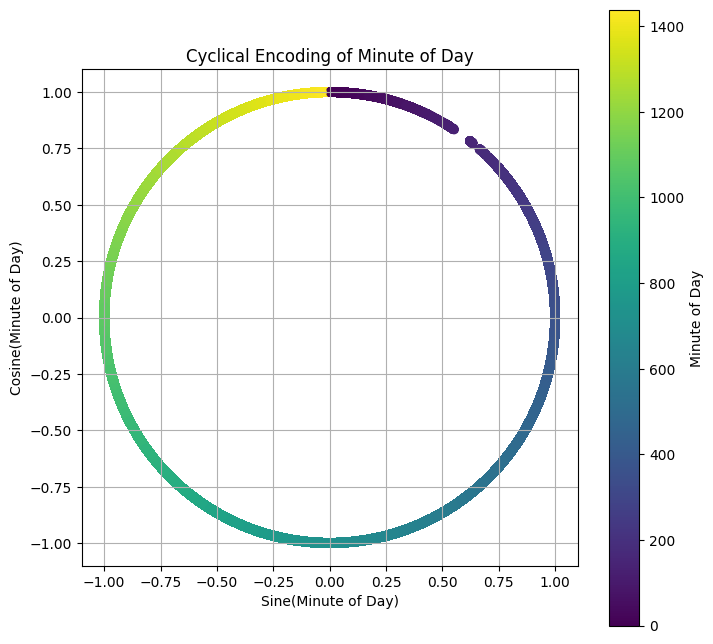

In [ ]:
plt.figure(figsize=(8, 8))
scatter = plt.scatter(
    mvg_data['minuteSin'],
    mvg_data['minuteCos'],
    c=mvg_data['minuteOfDay'], # Color points by the original minute of the day
    cmap='viridis'            # Use a nice color map
)

plt.gca().set_aspect('equal', adjustable='box')

plt.title('Cyclical Encoding of Minute of Day')
plt.xlabel('Sine(Minute of Day)')
plt.ylabel('Cosine(Minute of Day)')

# Add a colorbar to show what the colors mean
cbar = plt.colorbar(scatter)
cbar.set_label('Minute of Day')

plt.grid(True)
plt.show()

In [ ]:
mvg_data.sample(5)

,station,plannedDepartureTime,realtime,delayInMinutes,label,destination,onTime,plannedDepartureTime_dt,minuteOfDay,minuteSin,...,isMajorEvent,isHoliday,isAllianzArenaEvent,tempMin,tempMax,tempAvg,rainfall,sunHours,windMax,snowfall
2909997,de:09162:520,2024-09-02 11:12:00+00:00,True,0,U6,"Garching, Forschungszentrum",True,2024-09-02 11:12:00+00:00,672,0.207912,...,False,False,False,18.4,27.2,22.0,0.0,8.2,30.0,0
984493,de:09162:1130,2024-04-01 13:04:00+00:00,True,0,U6,Fröttmaning,True,2024-04-01 13:04:00+00:00,784,-0.275637,...,False,True,False,7.7,16.4,11.1,0.7,0.0,70.0,0
589211,de:09162:1490,2025-04-04 19:05:00+00:00,True,0,U6,Fürstenried West,True,2025-04-04 19:05:00+00:00,1145,-0.960050,...,False,False,False,3.8,19.5,11.5,0.0,12.8,35.0,0
1720331,de:09162:430,2024-07-30 14:31:00+00:00,True,0,U6,Klinikum Großhadern,True,2024-07-30 14:31:00+00:00,871,-0.612217,...,False,False,False,13.0,30.3,22.1,0.0,14.3,22.0,0
1585953,de:09162:420,2025-02-28 06:18:00+00:00,True,0,U6,Goetheplatz,True,2025-02-28 06:18:00+00:00,378,0.996917,...,False,False,False,1.1,6.0,3.6,0.0,0.8,36.0,0


In [ ]:
features = mvg_data.drop(['delayInMinutes', 'onTime', 'plannedDepartureTime', 'plannedDepartureTime_dt', 'realtime', 'minuteOfDay', 'onTime', 'tempMax', 'tempMin'], axis=1)
target = mvg_data['onTime']

features_encoded = pd.get_dummies(features, columns=['station', 'label', 'destination'])
features_encoded.columns = [re.sub(r'[^A-Za-z0-9_]+', '_', col) for col in features_encoded.columns]
print(f"Columns after sanitization: {features_encoded.shape[1]}")
features_encoded = features_encoded.loc[:, ~features_encoded.columns.duplicated()]
print(f"Columns after removing duplicates: {features_encoded.shape[1]}")


print(f"Total rows in the full dataset: {len(features_encoded)}")

X_sample, _, y_sample, _ = train_test_split(features_encoded, target, train_size=5_000, random_state=0, stratify=target)
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_sample, y_sample, test_size=0.3, random_state=0)
X_val_sample, X_test_sample, y_val_sample, y_test_sample = train_test_split(X_test_sample, y_test_sample, test_size=0.5, random_state=0)

print(f"\nSampled training set size: {len(X_train_sample)}")
print(f"Sampled validation set size: {len(X_val_sample)}")
print(f"Sampled test set size: {len(X_test_sample)}")


X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(features_encoded, target, test_size=0.3, random_state=0)
X_val_full, X_test_full, y_val_full, y_test_full = train_test_split(X_test_full, y_test_full, test_size=0.5, random_state=0)

print(f"\nFull training set size: {len(X_train_full)}")
print(f"Full validation set size: {len(X_val_full)}")
print(f"Full test set size: {len(X_test_full)}")

train_data_full = pd.concat([X_train_full, y_train_full], axis=1)
target_column_name = y_train_full.name

ontime_samples = train_data_full[train_data_full[target_column_name]]
delay_samples = train_data_full[~train_data_full[target_column_name]]

ontime_downsampled = ontime_samples.sample(n=len(delay_samples), random_state=0)

train_data_balanced = pd.concat([ontime_downsampled, delay_samples])

X_train_balanced = train_data_balanced.drop(columns=[target_column_name])
y_train_balanced = train_data_balanced[target_column_name]

print("\nOriginal full training class distribution:")
print(y_train_full.value_counts())
print("\nBalanced training class distribution:")
print(y_train_balanced.value_counts())

Columns after sanitization: 73
Columns after removing duplicates: 72
Total rows in the full dataset: 3453930

Sampled training set size: 3500
Sampled validation set size: 750
Sampled test set size: 750

Full training set size: 2417751
Full validation set size: 518089
Full test set size: 518090

Original full training class distribution:
onTime
True     2268021
False     149730
Name: count, dtype: int64

Balanced training class distribution:
onTime
True     149730
False    149730
Name: count, dtype: int64


In [ ]:
def train_and_evaluate_rf(params, X_train, y_train, X_val, y_val):
    """Trains a Random Forest and returns both train and validation F1-scores."""
    model = RandomForestClassifier(
        **params,
        n_jobs=-1,
        random_state=0
    )
    #model = lgb.LGBMClassifier(
    #    random_state=0,
    #    n_jobs=-1,
    #    **params
    #)
    model.fit(X_train, y_train)

    val_pred = model.predict(X_val)
    train_pred = model.predict(X_train)

    # Calculate F1-score specifically for the 'Delayed' class (which is 'False')
    # This is the metric we want to maximize to improve precision
    train_f1 = f1_score(y_train, train_pred, pos_label=False)

    # Calculate F1-score specifically for the 'Delayed' class (which is 'False')
    # This is the metric we want to maximize to improve precision
    val_f1 = f1_score(y_val, val_pred, pos_label=False)

    return params, train_f1, val_f1

In [ ]:
train_data_sample = pd.concat([X_train_sample, y_train_sample], axis=1)
target_column_name_sample = y_train_sample.name

ontime_samples_s = train_data_sample[train_data_sample[target_column_name_sample]]
delay_samples_s = train_data_sample[~train_data_sample[target_column_name_sample]]
ontime_downsampled_s = ontime_samples_s.sample(n=len(delay_samples_s), random_state=0)
train_data_balanced_s = pd.concat([ontime_downsampled_s, delay_samples_s])

X_train_sample_balanced = train_data_balanced_s.drop(columns=[target_column_name_sample])
y_train_sample_balanced = train_data_balanced_s[target_column_name_sample]


#estimators_to_test = range(10, 501, 10)
param_grid_definition = {
    'n_estimators': range(10, 501, 10),
    'min_samples_leaf': [1, 2, 3, 4, 5, 10, 20],
    'max_depth': [10, 15, 20, None],
}
params_to_test = list(ParameterGrid(param_grid_definition))
print(f"Generated {len(params_to_test)} parameter combinations to test.")
print("First 3 combinations:")
print(params_to_test[:3])


results = Parallel(n_jobs=-1)(
    delayed(train_and_evaluate_rf)(
        params,
        X_train_sample_balanced,
        y_train_sample_balanced,
        X_val_sample,
        y_val_sample
    ) for params in params_to_test
)
results_df = pd.DataFrame(results, columns=['params', 'train_f1_score', 'validation_f1_score'])

Generated 1400 parameter combinations to test.
First 3 combinations:
[{'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 10}, {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 20}, {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 30}]



--- Hyperparameter Tuning Complete ---
Best Validation F1-Score (for 'Delayed' class): 0.2036
Best Parameters Found:
{'max_depth': 20, 'min_samples_leaf': 2, 'n_estimators': 160}


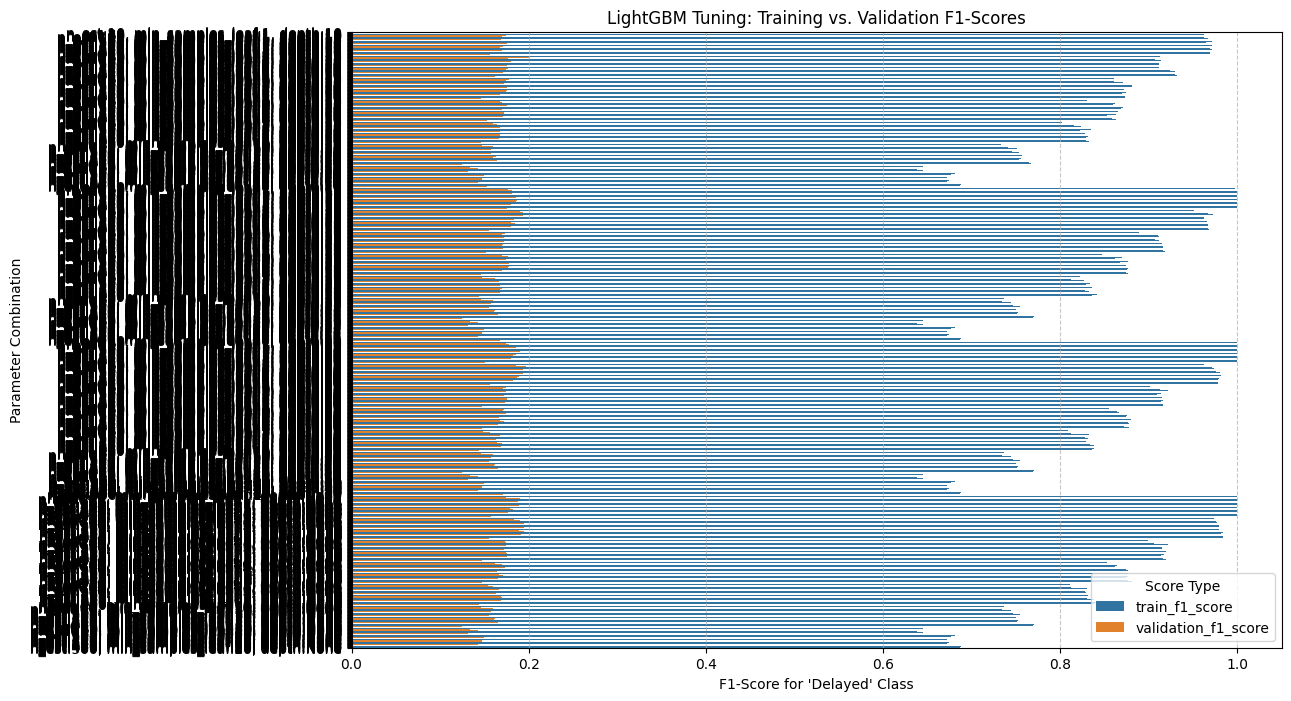

In [ ]:
best_params, _, best_val_f1_score = max(results, key=lambda item: item[2])

print("\n--- Hyperparameter Tuning Complete ---")
print(f"Best Validation F1-Score (for 'Delayed' class): {best_val_f1_score:.4f}")
print("Best Parameters Found:")
print(best_params)

def format_params(p_dict):
    return (f"n_est:{p_dict.get('n_estimators', 'N/A')}, "
            f"min_samples_leaf:{p_dict.get('min_samples_leaf', 'N/A')}, "
            f"depth:{p_dict.get('max_depth', 'N/A')}")
results_df['param_label'] = results_df['params'].apply(format_params)

df_melted = results_df.melt(
    id_vars='param_label',
    value_vars=['train_f1_score', 'validation_f1_score'],
    var_name='score_type',
    value_name='f1_score'
)

plt.figure(figsize=(12, 8))
sns.barplot(x='f1_score', y='param_label', hue='score_type', data=df_melted, orient='h')

plt.title('LightGBM Tuning: Training vs. Validation F1-Scores')
plt.xlabel("F1-Score for 'Delayed' Class")
plt.ylabel("Parameter Combination")
plt.legend(title='Score Type')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
#best_parameter = max(validation_results, key=validation_results.get)
#
#best_accuracy = validation_results[best_parameter]
#
#print(f"The best parameter is: {best_parameter}")
#print(f"With a validation accuracy of: {best_accuracy:.4f}")

In [ ]:
final_model = RandomForestClassifier(
    **best_params,
    n_jobs=-1,
    verbose=1,
    random_state=0
)
#final_model = lgb.LGBMClassifier(
#    **best_params,
#    n_jobs=-1,
#    verbose=-1,
#    random_state=0
#)

print(f"Training final model on {len(X_train_balanced)} samples...")
final_model.fit(X_train_balanced, y_train_balanced)

Training final model on 299460 samples...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   10.6s finished


,n_estimators,160
,criterion,'gini'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


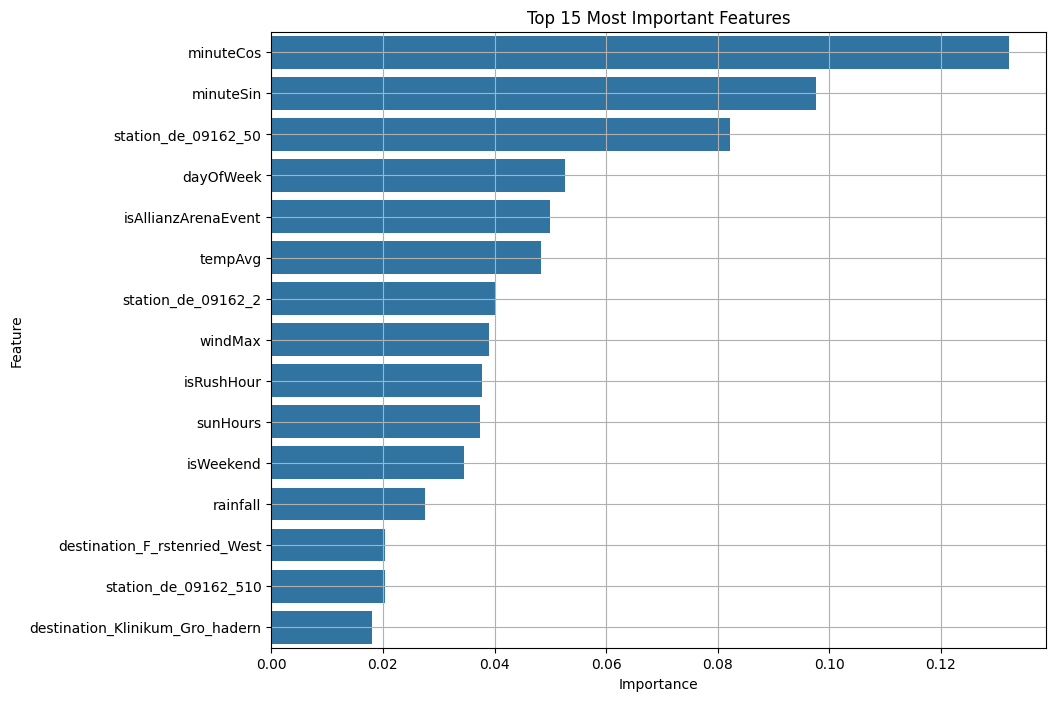

In [ ]:
importances = final_model.feature_importances_
feature_names = X_train_full.columns

feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False).head(15)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Top 15 Most Important Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(True)
plt.show()

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 160 out of 160 | elapsed:    1.5s finished


Classification Report:
              precision    recall  f1-score   support

       False       0.19      0.85      0.31     32306
        True       0.99      0.76      0.86    485784

    accuracy                           0.76    518090
   macro avg       0.59      0.80      0.58    518090
weighted avg       0.94      0.76      0.82    518090



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 160 out of 160 | elapsed:    1.5s finished


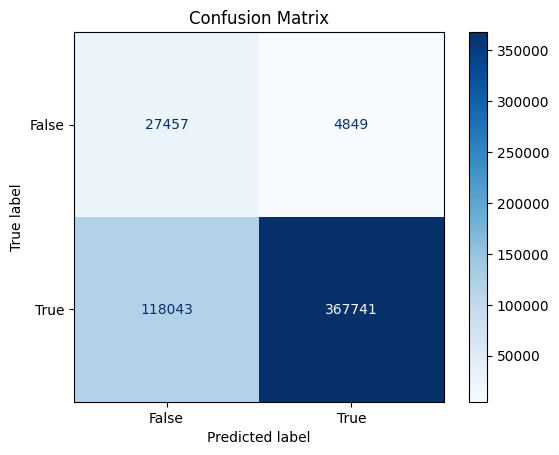

In [ ]:
y_pred = final_model.predict(X_test_full)

print("Classification Report:")
print(classification_report(y_test_full, y_pred))

disp = ConfusionMatrixDisplay.from_estimator(
    final_model,
    X_test_full,
    y_test_full,
    cmap=plt.cm.Blues
)
disp.ax_.set_title('Confusion Matrix')
plt.show()